<a href="https://colab.research.google.com/github/Kumar-Sanket/animalclassification/blob/main/Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# Import libraries

!pip install torch torchvision scikit-learn seaborn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



In [4]:
# Dataset

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/Mobile_Phone_Pricing/dataset.csv"

df = pd.read_csv(dataset_path)
print(df.head())
print(df.info())



Mounted at /content/drive
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  

In [5]:

# Preprocessing

X = df.drop("price_range", axis=1).values
y = df["price_range"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)


In [6]:

# Neural Network

class PriceNet(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(PriceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = PriceNet(input_dim=input_dim).to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
print(model)


PriceNet(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [7]:

# Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss:.4f}, Val Acc: {acc:.4f}")


Epoch [1/30], Loss: 33.5024, Val Acc: 0.5750
Epoch [2/30], Loss: 27.4087, Val Acc: 0.6000
Epoch [3/30], Loss: 22.8739, Val Acc: 0.6225
Epoch [4/30], Loss: 20.3088, Val Acc: 0.6625
Epoch [5/30], Loss: 18.5969, Val Acc: 0.7025
Epoch [6/30], Loss: 16.6863, Val Acc: 0.7400
Epoch [7/30], Loss: 15.4304, Val Acc: 0.7800
Epoch [8/30], Loss: 14.7122, Val Acc: 0.8000
Epoch [9/30], Loss: 13.6493, Val Acc: 0.8275
Epoch [10/30], Loss: 12.6310, Val Acc: 0.8450
Epoch [11/30], Loss: 11.6456, Val Acc: 0.8775
Epoch [12/30], Loss: 11.7656, Val Acc: 0.8975
Epoch [13/30], Loss: 10.3038, Val Acc: 0.9100
Epoch [14/30], Loss: 10.3786, Val Acc: 0.9025
Epoch [15/30], Loss: 9.8772, Val Acc: 0.9000
Epoch [16/30], Loss: 9.6061, Val Acc: 0.9075
Epoch [17/30], Loss: 8.3084, Val Acc: 0.9225
Epoch [18/30], Loss: 7.9742, Val Acc: 0.9225
Epoch [19/30], Loss: 7.4139, Val Acc: 0.9200
Epoch [20/30], Loss: 7.9793, Val Acc: 0.9225
Epoch [21/30], Loss: 7.4168, Val Acc: 0.9325
Epoch [22/30], Loss: 7.7894, Val Acc: 0.9375
Epoch


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       100
           1       0.94      0.88      0.91       100
           2       0.94      0.91      0.92       100
           3       0.95      0.99      0.97       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



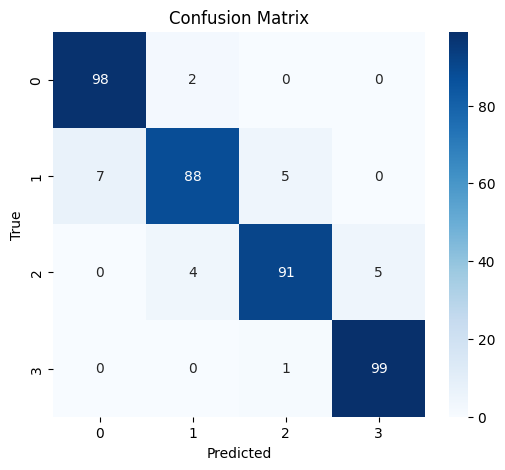

In [8]:

# Final Evaluation

model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))
    _, y_pred = torch.max(outputs, 1)

print("\nClassification Report:\n", classification_report(y_test, y_pred.cpu()))

cm = confusion_matrix(y_test, y_pred.cpu())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [9]:

# Inference Function

def predict_price(features: dict):
    df_input = pd.DataFrame([features])
    df_input_scaled = scaler.transform(df_input)
    x_tensor = torch.tensor(df_input_scaled, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x_tensor)
        pred = torch.argmax(logits, dim=1).item()
    return pred

# Example usage
sample = df.drop("price_range", axis=1).iloc[0].to_dict()
print("\nSample Prediction:", predict_price(sample))



Sample Prediction: 1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
